In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
import time
import xarray as xr

import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("notebook") #[poster, paper, talk, notebook]


## functions
STATS

In [2]:
# ~~~~ function, Histogram
def histogram(x, binx):
    '''
    makes histogram for all values >0 in lidar images
    '''

    hist, bin_x = np.histogram(x[x !=0], bins=binx)
    return hist, bin_x[:-1]


# ~~~~ function, Step plot
def step_hist_plt(hist, bin_x, date_iter, axis, line_color, date_label, alpha=0.4, lw=2, shaded=True):
    '''
    computes step plot for histogram values
    '''

    if shaded is True:
      axis.step(bin_x, hist, lw=lw, c=line_color, label = date_label)
      axis.fill_between(bin_x, hist, step="pre", alpha=alpha)

    if shaded is False:
      axis.step(bin_x, hist, lw=lw, c=line_color, label = date_label)
  

# ~~~~ function, Means
def get_mean(x):
    '''
    computes mean snow depth (within basin)
    '''
    
    mu = np.nanmean(x)
    return mu


# ~~~~ function, Standard Deviation
def get_std(x):
    '''
    computes mean snow depth (within basin)
    '''
    
    std = np.nanstd(x)
    return std

PLOTTING

In [3]:
def color_palette(palette_type, flight_count, show_pal=False):
    '''
    This method gives options to the color scheme for line plots

    args:
        palette_type: color scheme [qualitative 'q', sequential 's', diverge 'd']
        flight_count: number of flights to process
        show_pal: see output or not after running option

    '''
    if palette_type is 'q' : #'qualitative' or 'q':
    # qualitative:
        c_pal = sns.color_palette("Dark2", flight_count)
        if show_pal==True:
            c_shw = sns.palplot(c_pal)


    elif palette_type is 's' : #'sequential' or 's':
    # sequential:
        c_pal = sns.color_palette(sns.cubehelix_palette(flight_count, start=.7, rot=-.75,dark=.25, light=.75)) # create color palette (plt.plot(c=c_pal[i]))
        if show_pal==True:
            c_shw = sns.palplot(sns.cubehelix_palette(flight_count, start=.7, rot=-.75,dark=.25, light=.75)) # show colors


    elif palette_type is 'd' : #'diverge' or 'd':
    # diverging:
        c_pal = sns.color_palette("RdBu_r", flight_count)
        if show_pal==True:
            c_shw = sns.palplot(c_pal)

    return c_pal


def make_my_super_plot(ds, title = '', color_scheme = 'q', xlim=[0,600]):
    '''
    This method plots a stair step histogram plot for the lidar snow depth data. 
    
        args:
            ds: xarray DataSet in [mm], plots in [cm]
            title: set when you call the function
            color_scheme: qualitative, sequential, or diverge
            xlim: control xlims
            
    '''
    
    d_str = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")
    binx = np.arange(0,2500,1) #(start, stop, step by [cm])
    # binx = np.arange(0,250,0.01)

    f=plt.figure(num=0, figsize=(14,7))
    a=plt.gca()
    c_pal = color_palette(color_scheme, ds.time.size)

    with ProgressBar(): #SAVED FIGS FROM HERE
        for i in range(ds.time.size):
            hist, bin_x = xr.apply_ufunc(histogram, ds.snow[i].values/10, binx, dask='parallelized', output_dtypes=[np.float32])
            step_hist_plt(hist, bin_x, i, a, c_pal[i], d_str[i], alpha=0.2, lw=4, shaded=False)

        a.set_title(title)
        a.set_xlim(*xlim)
        a.set_xlabel('snow depth [cm]')
        a.set_ylabel('frequency')
        a.legend()
        a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        plt.tight_layout()
        plt.show()

## set up

In [4]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc'
which_year = 2018
peak = False

## main function

In [5]:
def main(fname, which_year, peak=False):

    #ds full
    ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
    ds.close()


    if peak:
        #~~~~~~~~~~~ds peak
        dpeak = ds.isel(time=[0,7,18,30,42,49]) 
        dpeak.close()

        ds = dpeak
        ds.close()
        ds
        temp_title = 'Snow distribution nearest peak SWE flight date'
        make_my_super_plot(ds,title=temp_title, color_scheme='q')

    else:
        #~~~~~~~~~~~~~~ds small
        dsmall = ds.sel(time='{}'.format(which_year))
        dsmall.close()

        ds = dsmall
        ds.close()
        temp_title = '{} snow depth distribution, binx=1 [cm]'.format(which_year)
        make_my_super_plot(ds,title=temp_title, color_scheme='s', xlim=[0,600])


## call main

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.5s


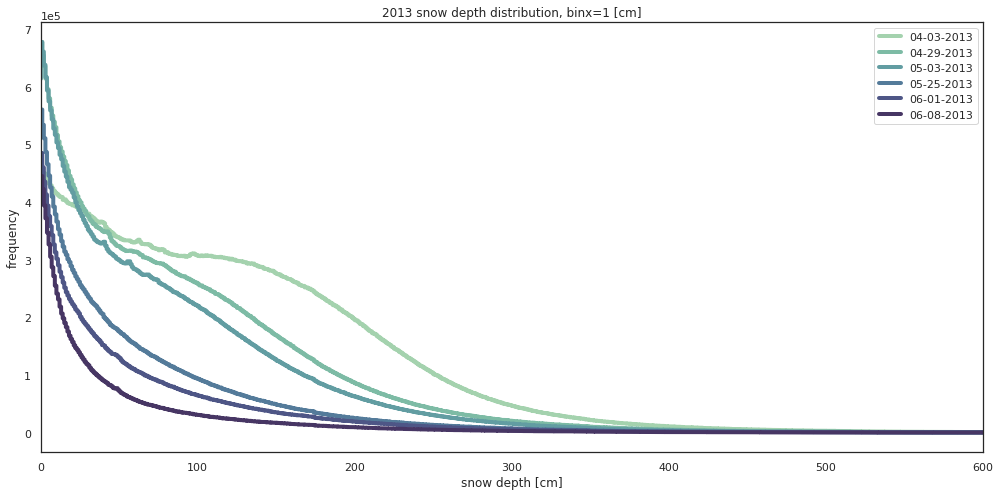

In [6]:
if __name__ == "__main__":
    # for yr in range(2013,2019):
    #     main('~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc',yr)


    main('~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc',2013, peak=False)

In [7]:
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(51, 17002, 17569), chunksize=(1, 1000, 1000)>

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/matplotlib/transforms.py:2902: RuntimeWarning: overflow encountered in short_scalars
  elif vmax - vmin <= maxabsvalue * tiny:


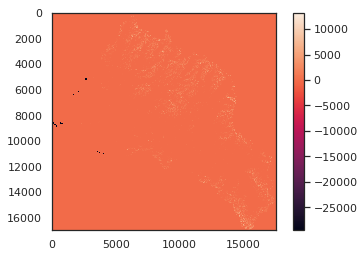

In [8]:
plt.imshow(ds.isel(time=36).snow)
plt.colorbar()